In [1]:
print('Hello world')

Hello world


In [2]:
dataset_base_path = '/kaggle/input/asd-dataset/Dataset/'
print(f"Dataset base path set to: {dataset_base_path}")

Dataset base path set to: /kaggle/input/asd-dataset/Dataset/


In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Supported image extensions
image_extensions = ('.jpg', '.jpeg', '.png')

# Dictionary to store image paths
data_paths = {
    'Train': {'autistic': [], 'typical': []},
    'valid': {'autistic': [], 'typical': []},
    'Test':  {'autistic': [], 'typical': []}
}

# Collect image paths
for split in data_paths.keys():
    for category in data_paths[split].keys():
        folder_path = os.path.join(dataset_base_path, split, category)

        if os.path.isdir(folder_path):
            for file_name in sorted(os.listdir(folder_path)):
                if file_name.lower().endswith(image_extensions):
                    full_path = os.path.join(folder_path, file_name)
                    data_paths[split][category].append(full_path)
        else:
            print(f"Warning: Directory not found -> {folder_path}")

# Summary
print("Total images collected:")
for split in data_paths:
    for category in data_paths[split]:
        print(f"{split}/{category}: {len(data_paths[split][category])}")

Total images collected:
Train/autistic: 1268
Train/typical: 1268
valid/autistic: 50
valid/typical: 50
Test/autistic: 150
Test/typical: 150


Showing first 10 images from Train/autistic
Error loading image /kaggle/input/asd-dataset/Dataset/Train/autistic/0004.jpg: cannot identify image file '/kaggle/input/asd-dataset/Dataset/Train/autistic/0004.jpg'


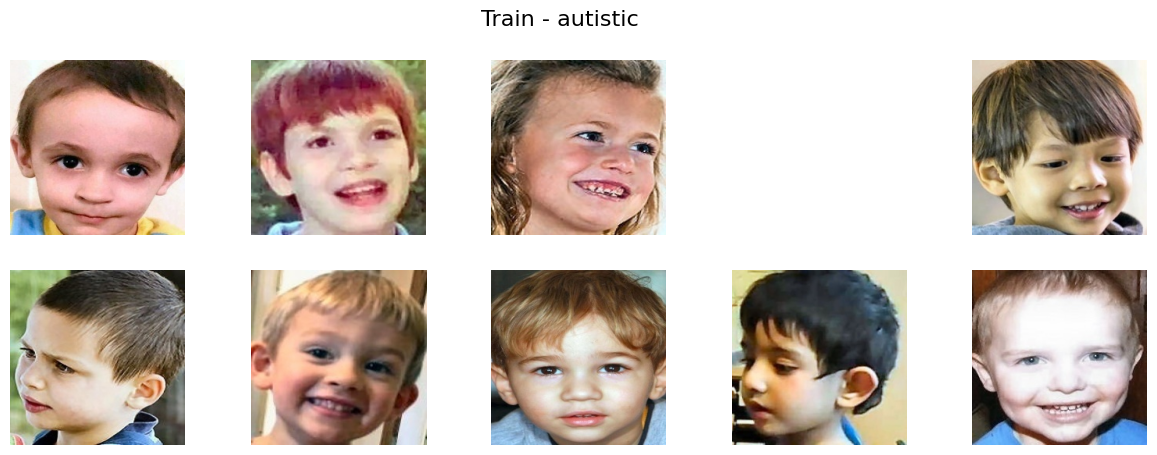

Showing first 10 images from Train/typical


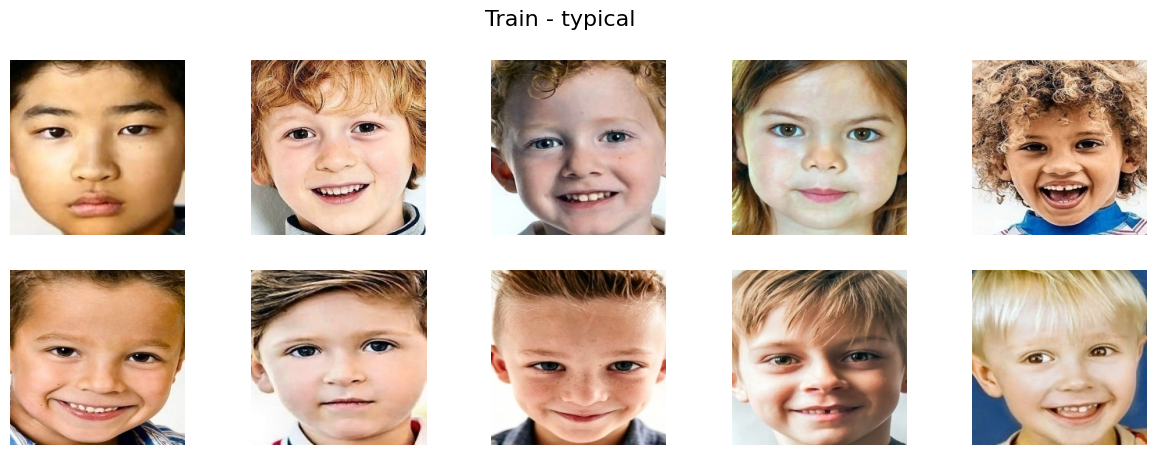

Showing first 10 images from valid/autistic


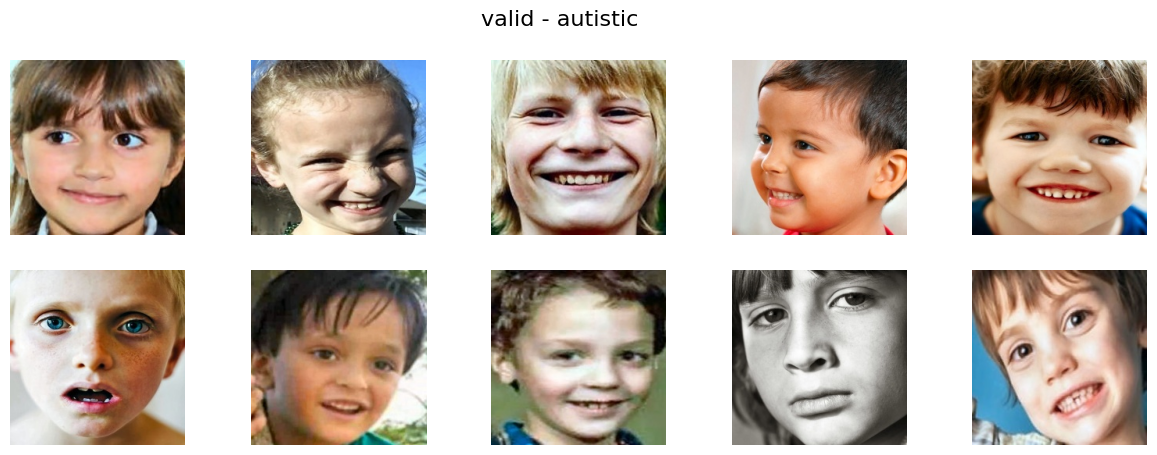

Showing first 10 images from valid/typical


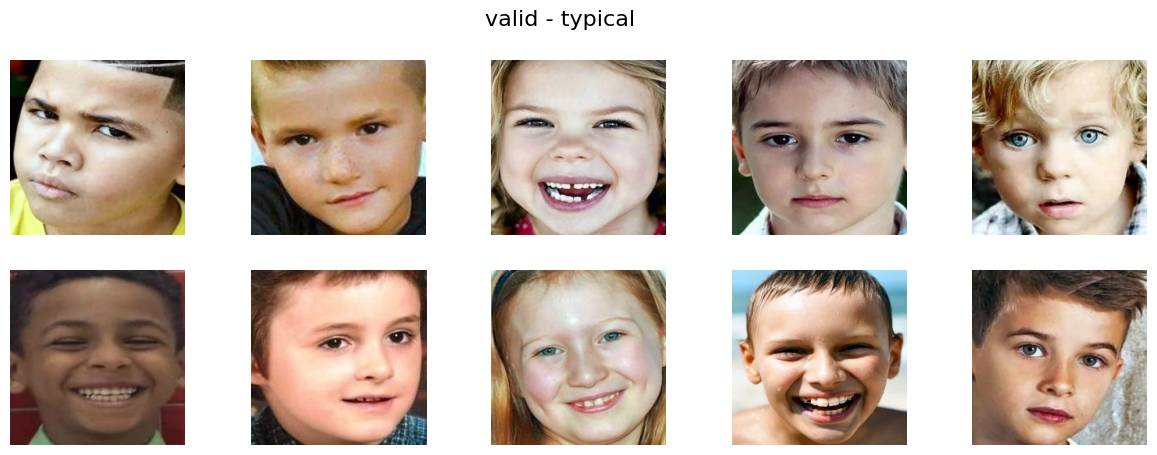

Showing first 10 images from Test/autistic
Error loading image /kaggle/input/asd-dataset/Dataset/Test/autistic/010.jpg: cannot identify image file '/kaggle/input/asd-dataset/Dataset/Test/autistic/010.jpg'


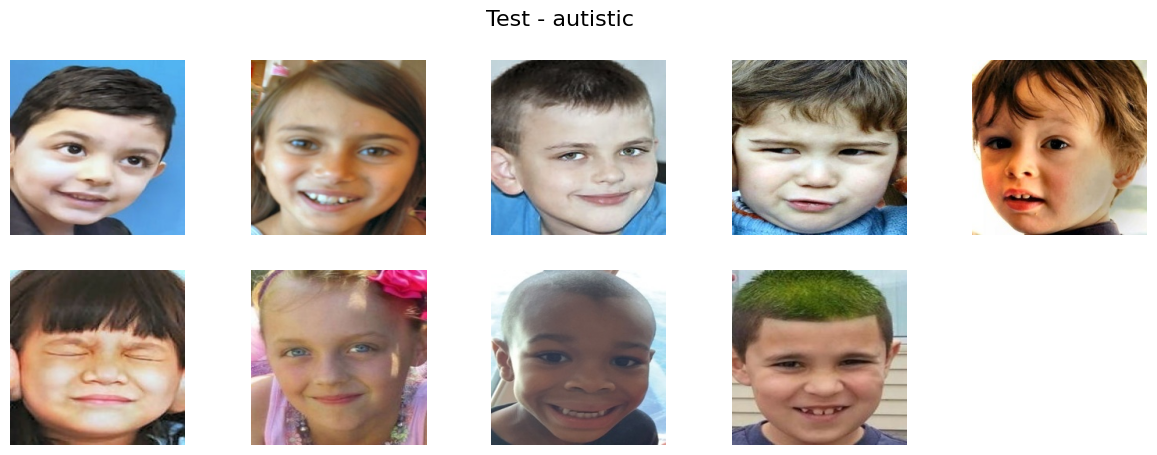

Showing first 10 images from Test/typical
Error loading image /kaggle/input/asd-dataset/Dataset/Test/typical/009.jpg: cannot identify image file '/kaggle/input/asd-dataset/Dataset/Test/typical/009.jpg'


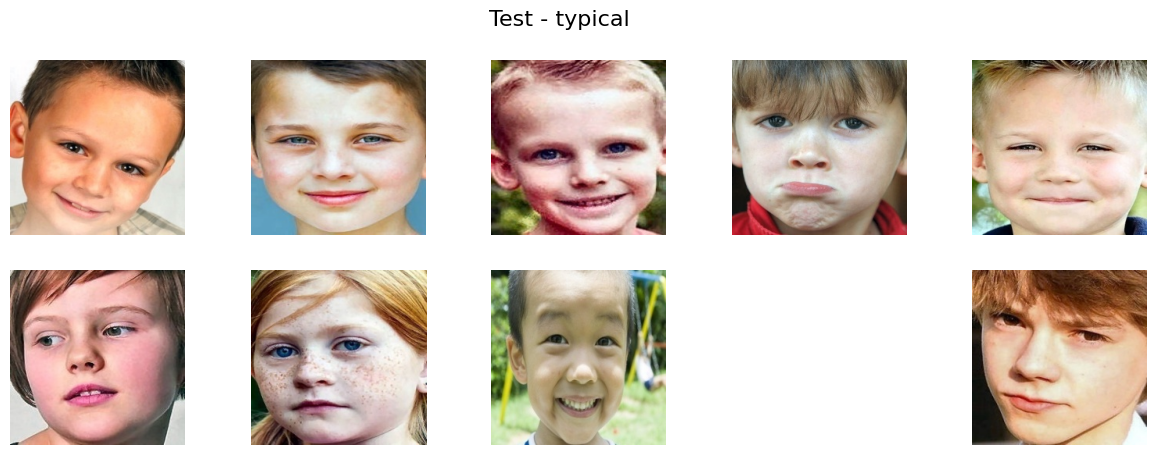

In [4]:
def show_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths[:10]):
        try:
            img = Image.open(img_path).convert("RGB")
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    plt.suptitle(title, fontsize=16)
    plt.show()


# Display images for each split and category
for split in ['Train', 'valid', 'Test']:
    for category in ['autistic', 'typical']:
        print(f"Showing first 10 images from {split}/{category}")
        show_images(
            data_paths[split][category],
            title=f"{split} - {category}"
        )

In [5]:
import tensorflow as tf

IMG_SIZE = (224, 224)

def validate_split_parallel(paths_list):
    """
    Uses tf.data to parallelize decoding and resizing to find corrupted images.
    """
    if not paths_list:
        return []

    # 1. Create a dataset of paths
    path_ds = tf.data.Dataset.from_tensor_slices(paths_list)

    def is_valid_tf(path):
        def _print_error_message(path_tensor, error_message_tensor):
            # Decode bytes to string for Python print function
            # path_tensor and error_message_tensor are tf.Tensor objects here
            print(f"Corrupted image detected: {path_tensor.numpy().decode('utf-8')} - Error: {error_message_tensor.numpy().decode('utf-8')}")

        try:
            # This mimics exactly what happens during training
            img_raw = tf.io.read_file(path)
            # Explicitly check if the file content is empty
            if tf.equal(tf.strings.length(img_raw), 0):
                tf.py_function(
                    func=_print_error_message,
                    inp=[path, tf.constant("empty file", dtype=tf.string)],
                    Tout=[] # No output from this function
                )
                return path, False

            # If the file is 'empty' or not a JPEG/PNG, this line will fail
            img = tf.image.decode_image(img_raw, channels=3, expand_animations=False)
            # Ensure it can actually be resized
            img = tf.image.resize(img, IMG_SIZE)
            return path, True
        except Exception as e:
            tf.py_function(
                func=_print_error_message,
                inp=[path, tf.constant(str(e), dtype=tf.string)], # Pass exception message as a tf.string
                Tout=[]
            )
            return path, False

    # 2. Map the validation function across multiple CPU threads
    # AUTOTUNE handles the parallel execution for speed on Google Drive
    validated_ds = path_ds.map(is_valid_tf, num_parallel_calls=tf.data.AUTOTUNE)

    # 3. Collect only the successful paths
    valid_paths = []
    for path, is_valid in validated_ds.as_numpy_iterator():
        if is_valid:
            valid_paths.append(path.decode('utf-8'))

    return valid_paths

# Initialize your clean data structure
clean_data_paths = {
    'Train': {'autistic': [], 'typical': []},
    'valid': {'autistic': [], 'typical': []},
    'Test':  {'autistic': [], 'typical': []}
}

print("Validating images across all splits...")
for split in data_paths:
    for category in data_paths[split]:
        current_paths = data_paths[split][category]
        # Run the parallel validation
        clean_data_paths[split][category] = validate_split_parallel(current_paths)

# Summary
print("\nFinal count after removing corrupted/empty images:")
for split in clean_data_paths:
    for category in clean_data_paths[split]:
        print(f"{split}/{category}: {len(clean_data_paths[split][category])}")

2025-12-31 13:57:46.608113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767189466.825343      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767189466.885966      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767189467.416457      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767189467.416508      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767189467.416511      55 computation_placer.cc:177] computation placer alr

Validating images across all splits...


I0000 00:00:1767189481.060689      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767189481.064636      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0004.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0059.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0097.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0104.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0112.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0137.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0139.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0162.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Train/autistic/0174.jpg - Error: empty file
Corrupted image detected: /kaggle/input/asd-dataset/Dataset/Trai

In [6]:
BATCH_SIZE = 32

def build_dataset(image_paths, labels, training=False):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((path_ds, label_ds))

    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.shuffle(1000)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)

def prepare_split(split):
    images = []
    labels = []

    for category, label in zip(['autistic', 'typical'], [1, 0]):
        images.extend(clean_data_paths[split][category])
        labels.extend([label] * len(clean_data_paths[split][category]))

    return images, labels

train_imgs, train_labels = prepare_split('Train')
val_imgs, val_labels     = prepare_split('valid')
test_imgs, test_labels   = prepare_split('Test')

train_ds = build_dataset(train_imgs, train_labels, training=True)
val_ds   = build_dataset(val_imgs, val_labels)
test_ds  = build_dataset(test_imgs, test_labels)

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def decode_img(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3) # Assuming JPEG, can be generalized
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

def augment_img(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img, label

def build_dataset(image_paths, labels, training=False):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int64))
    image_label_ds = tf.data.Dataset.zip((path_ds, label_ds))

    if training:
        image_label_ds = image_label_ds.shuffle(buffer_size=len(image_paths))

    image_label_ds = image_label_ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        image_label_ds = image_label_ds.map(augment_img, num_parallel_calls=tf.data.AUTOTUNE)

    return image_label_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare the splits using the cleaned data paths
train_imgs, train_labels = prepare_split('Train')
val_imgs, val_labels     = prepare_split('valid')
test_imgs, test_labels   = prepare_split('Test')

# Build the datasets
train_ds = build_dataset(train_imgs, train_labels, training=True)
val_ds   = build_dataset(val_imgs, val_labels)
test_ds  = build_dataset(test_imgs, test_labels)

print("TensorFlow datasets (train_ds, val_ds, test_ds) have been successfully built.")

TensorFlow datasets (train_ds, val_ds, test_ds) have been successfully built.


In [9]:
import tensorflow as tf
import gc
from tensorflow.keras import backend as K

# 1. Reset the Keras global state
K.clear_session()

# 2. Delete the model variables if they exist in the current namespace
try:
    del model
    del base_model
except NameError:
    pass

# 3. Force Python's Garbage Collector to release unreferenced memory
gc.collect()

print("Memory cleared. You can now re-initialize your model.")

Memory cleared. You can now re-initialize your model.


In [10]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Transfer learning first

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,201 (9.26 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint( 
    filepath="/kaggle/working/best_asd_mobilenetv2.keras", # recommended Keras format 
    monitor="val_auc", # IMPORTANT 
    mode="max", save_best_only=True, verbose=1 )

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
     callbacks=[checkpoint]
)

Epoch 1/15
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8468 - auc: 0.9350 - loss: 0.3268
Epoch 1: val_auc improved from -inf to 0.84375, saving model to /kaggle/working/best_asd_mobilenetv2.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8469 - auc: 0.9349 - loss: 0.3270 - val_accuracy: 0.7423 - val_auc: 0.8438 - val_loss: 0.5116
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8576 - auc: 0.9419 - loss: 0.3131
Epoch 2: val_auc improved from 0.84375 to 0.84928, saving model to /kaggle/working/best_asd_mobilenetv2.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8578 - auc: 0.9419 - loss: 0.3129 - val_accuracy: 0.7629 - val_auc: 0.8493 - val_loss: 0.5047
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8507 - auc: 0.9379 - loss: 0.3218
Epoch 3: val_auc improved from 0.84928 to 0.85268, saving model to /kaggle/working/best_asd_mobilenetv2.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8507 - auc: 0.9379 - loss:

In [17]:
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8190 - auc: 0.5379 - loss: 0.4215  
Test Accuracy: 0.8256
Test AUC: 0.9039


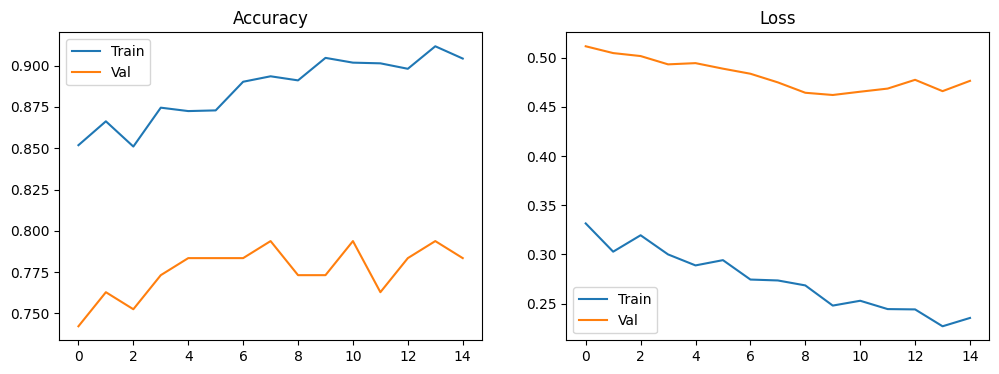

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()

In [25]:
import numpy as np

# 1. Use the predict() method of the trained model on the test_ds to obtain the predicted probabilities
y_pred_proba = model.predict(test_ds)

# 2. Iterate through the test_ds to extract the true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 3. Convert the predicted probabilities (y_pred_proba) into binary predictions (0 or 1)
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

print("Predictions made successfully.")
print(f"Shape of predicted probabilities: {y_pred_proba.shape}")
print(f"Shape of true labels: {y_true.shape}")
print(f"Shape of binary predictions: {y_pred_binary.shape}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predictions made successfully.
Shape of predicted probabilities: (281, 1)
Shape of true labels: (281,)
Shape of binary predictions: (281, 1)


In [26]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

TN, FP, FN, TP = cm.ravel()

# Calculate Sensitivity (Recall): TP / (TP + FN)
# Sensitivity measures the proportion of actual positive cases that were correctly identified.
sensitivity = TP / (TP + FN)

# Calculate Specificity: TN / (TN + FP)
# Specificity measures the proportion of actual negative cases that were correctly identified.
specificity = TN / (TN + FP)

print(f"Confusion Matrix:\n{cm}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Confusion Matrix:
[[115  25]
 [ 24 117]]
Sensitivity: 0.8298
Specificity: 0.8214


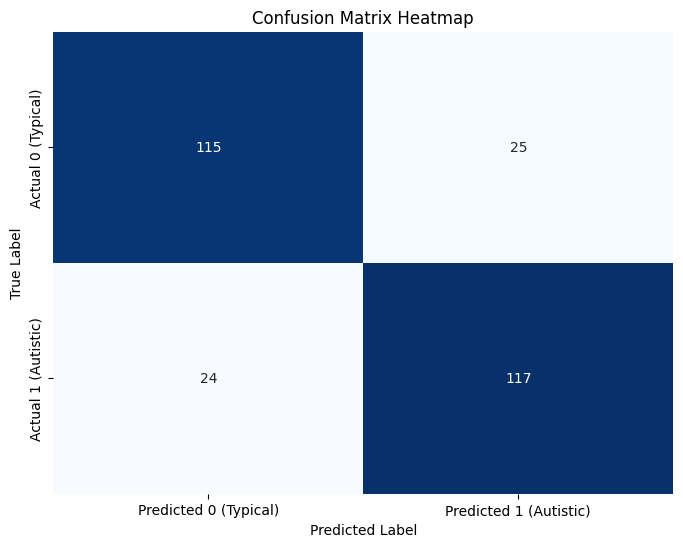

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted 0 (Typical)', 'Predicted 1 (Autistic)'],
    yticklabels=['Actual 0 (Typical)', 'Actual 1 (Autistic)']
)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Backbone
base_model = model.layers[0]  # MobileNetV2

# Classifier head (everything after backbone)
classifier_layers = model.layers[1:]


In [37]:
last_conv_layer_name = "Conv_1"
last_conv_layer = base_model.get_layer(last_conv_layer_name)


In [38]:
@tf.function
def gradcam_forward(img_tensor):
    with tf.GradientTape() as tape:
        # Forward through backbone
        conv_outputs = base_model(img_tensor, training=False)
        tape.watch(conv_outputs)

        x = conv_outputs
        for layer in classifier_layers:
            x = layer(x, training=False)

        preds = x[:, 0]  # sigmoid output

    grads = tape.gradient(preds, conv_outputs)
    return conv_outputs, grads


In [39]:
def make_gradcam_heatmap(img_array):
    conv_outputs, grads = gradcam_forward(img_array)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()


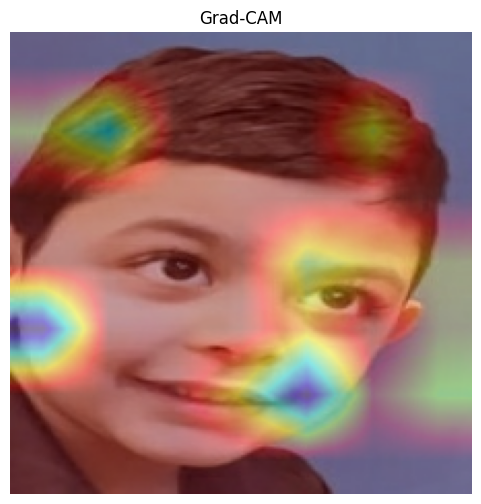

In [40]:
# Get one test image
for images, labels in test_ds.take(1):
    img = images[0]
    break

img_array = tf.expand_dims(img, axis=0)

heatmap = make_gradcam_heatmap(img_array)

# Resize and overlay
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img_np = np.uint8(img.numpy() * 255)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM")
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-31 14:27:25.216239: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-31 14:27:25.367755: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-31 14:27:25.504815: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

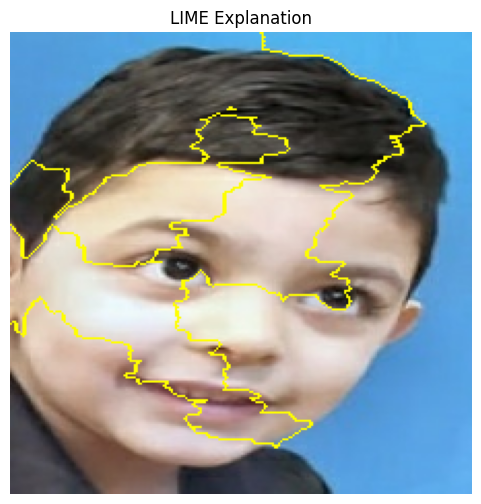

In [45]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import tensorflow as tf

def predict_fn(images):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    preds = model.predict(images)
    return np.hstack([1 - preds, preds])
explainer = lime_image.LimeImageExplainer()

image = test_images[0]

explanation = explainer.explain_instance(
    image,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
plt.title("LIME Explanation")
plt.show()


In [49]:
def generate_asd_reasoning(explanation, img_shape=(224, 224)):
    # Get the top segments (features) from LIME
    label = explanation.top_labels[0]
    top_features = sorted(explanation.local_exp[label], key=lambda x: abs(x[1]), reverse=True)[:3]
    
    reasons = []
    h, w = img_shape[0], img_shape[1]

    for feat_id, weight in top_features:
        # Get coordinates of this superpixel
        mask = (explanation.segments == feat_id)
        y, x = np.where(mask)
        avg_y, avg_x = np.mean(y), np.mean(x)

        # Logic to map coordinates to facial regions
        # Assuming image is a standard face crop
        if avg_y < h * 0.4:
            region = "Eyes/Forehead area"
        elif avg_y > h * 0.7:
            region = "Mouth/Chin area"
        elif h * 0.3 < avg_x < h * 0.7:
            region = "Nose/Central face"
        else:
            region = "Cheeks/Side profile"

        impact = "strong positive" if weight > 0 else "negative"
        reasons.append(f"- The model focused on the **{region}**, which had a {impact} influence on the result.")

    return "\n".join(reasons)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

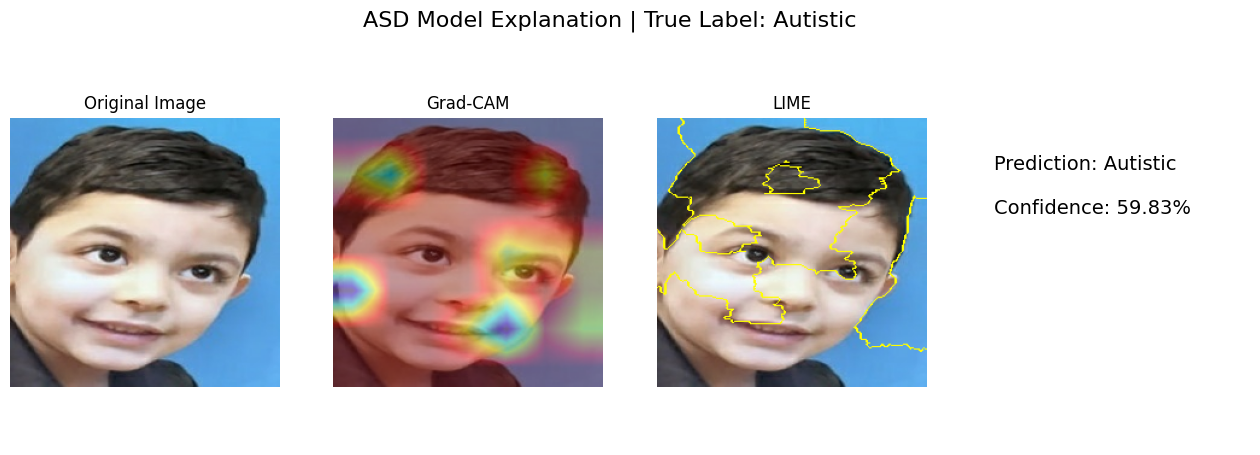

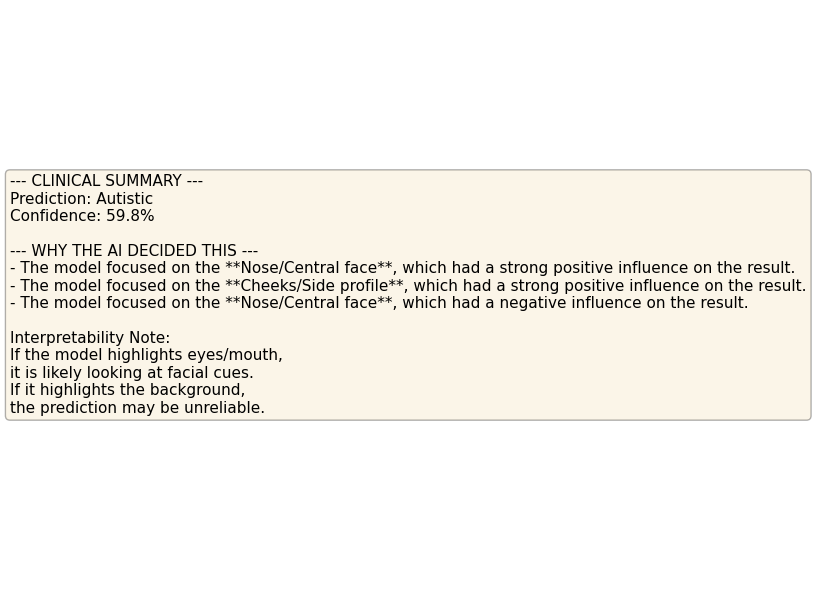

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.segmentation import mark_boundaries

# -------- Pick ONE test image --------
for images, labels in test_ds.take(1):
    img = images[0]
    true_label = labels[0].numpy()
    break

img_array = tf.expand_dims(img, axis=0)

# -------- Model prediction --------
prob = model.predict(img_array)[0][0]
pred_label = "Autistic" if prob > 0.5 else "Typical"
confidence = prob if prob > 0.5 else 1 - prob

# -------- Grad-CAM --------
heatmap = make_gradcam_heatmap(img_array)

heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img_np = np.uint8(img.numpy() * 255)
gradcam_overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# -------- LIME --------
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    img.numpy(),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

lime_img, lime_mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

lime_vis = mark_boundaries(lime_img, lime_mask)

# -------- Plot everything --------
plt.figure(figsize=(16,5))

plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(gradcam_overlay)
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(lime_vis)
plt.title("LIME")
plt.axis("off")

plt.subplot(1,4,4)
plt.text(
    0.05, 0.6,
    f"Prediction: {pred_label}\n\nConfidence: {confidence*100:.2f}%",
    fontsize=14
)
plt.axis("off")

plt.suptitle(
    f"ASD Model Explanation | True Label: {'Autistic' if true_label==1 else 'Typical'}",
    fontsize=16
)

plt.show()

# -------- Generate Text Reasoning --------
reasoning_text = generate_asd_reasoning(explanation)

# -------- Plot everything --------
plt.figure(figsize=(20, 6)) # Made it wider to fit text

# ... (keep your subplots 1, 2, and 3 the same) ...

plt.subplot(1,4,4)
summary_box = (
    f"--- CLINICAL SUMMARY ---\n"
    f"Prediction: {pred_label}\n"
    f"Confidence: {confidence*100:.1f}%\n\n"
    f"--- WHY THE AI DECIDED THIS ---\n"
    f"{reasoning_text}\n\n"
    f"Interpretability Note:\n"
    f"If the model highlights eyes/mouth,\n"
    f"it is likely looking at facial cues.\n"
    f"If it highlights the background,\n"
    f"the prediction may be unreliable."
)

plt.text(0.0, 0.5, summary_box, fontsize=11, verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

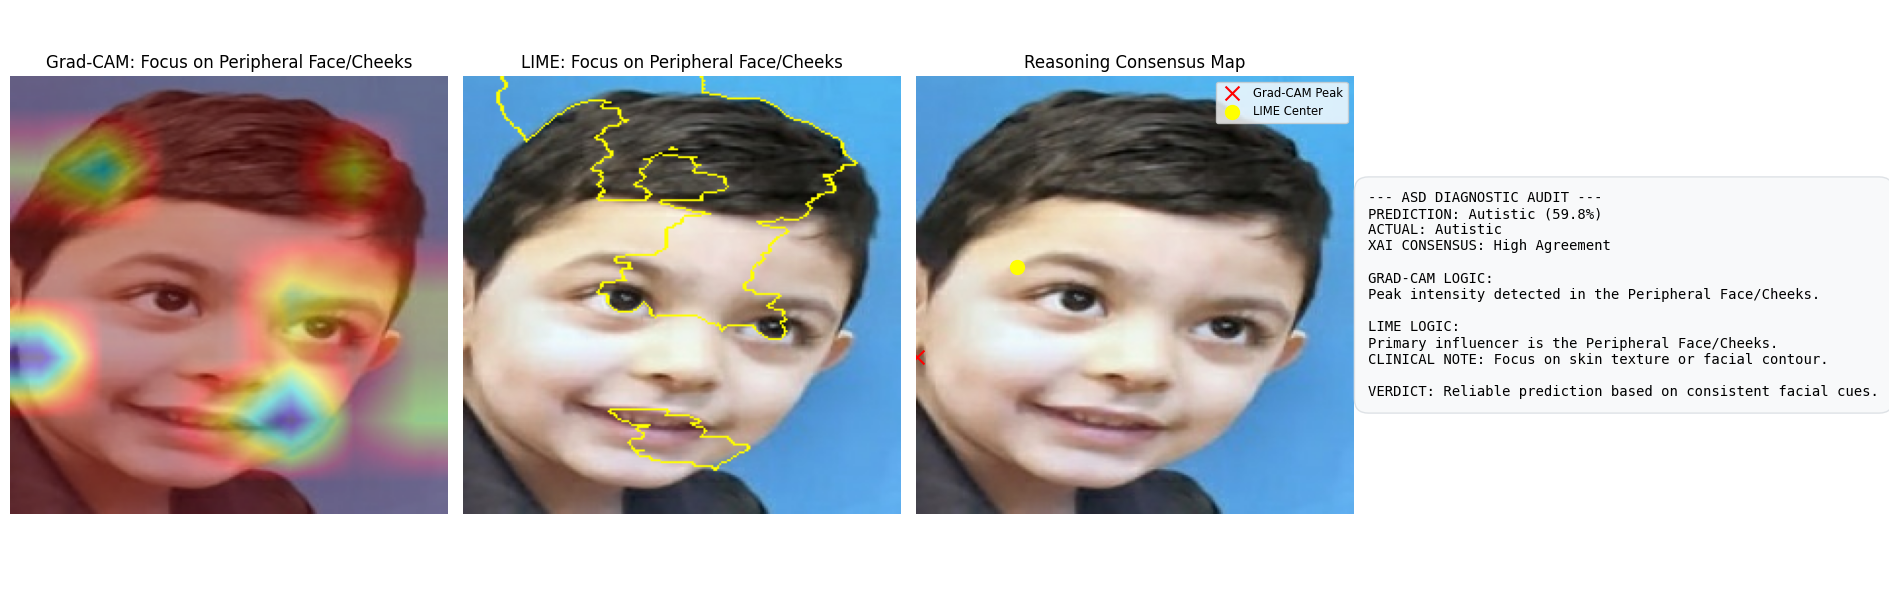

In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.segmentation import mark_boundaries

# --- 1. THE REASONING ENGINE (GEOMETRIC MAPPING) ---
def get_anatomical_reasoning(x_perc, y_perc):
    """
    Maps image coordinates (0-100%) to facial anatomy.
    This is robust and does not require MediaPipe/Dlib.
    """
    if y_perc < 40:
        region = "Ocular/Forehead Region"
        insight = "Focus on eyes/brow. Clinical marker for social gaze and attention."
    elif y_perc > 65:
        region = "Perioral/Jaw Region"
        insight = "Focus on mouth/chin. Relevant for affect and emotional expression."
    elif 40 <= x_perc <= 60:
        region = "Nasal/Central Face"
        insight = "Focus on mid-face symmetry and core morphology."
    else:
        region = "Peripheral Face/Cheeks"
        insight = "Focus on skin texture or facial contour."
    return region, insight

# --- 2. THE INTEGRATED EXPLANATION CELL ---
# Note: This assumes you have 'model', 'test_ds', 'make_gradcam_heatmap', and 'predict_fn' defined.

# A. Pick a test image
for images, labels in test_ds.take(1):
    img = images[0]
    true_label = "Autistic" if labels[0].numpy() == 1 else "Typical"
    img_np = (img.numpy() * 255).astype(np.uint8) if img.numpy().max() <= 1.0 else img.numpy().astype(np.uint8)
    break

img_array = tf.expand_dims(img, axis=0)

# B. Model Prediction
preds = model.predict(img_array)
prob = preds[0][0]
pred_label = "Autistic" if prob > 0.5 else "Typical"
confidence = prob if prob > 0.5 else 1 - prob

# C. Grad-CAM Calculation
heatmap = make_gradcam_heatmap(img_array)
heatmap = cv2.resize(heatmap, (224, 224))
# Find Grad-CAM peak (most important point)
y_cam, x_cam = np.unravel_index(np.argmax(heatmap), heatmap.shape)
cam_region, _ = get_anatomical_reasoning((x_cam/224)*100, (y_cam/224)*100)

# D. LIME Calculation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img.numpy().astype('double'), predict_fn, top_labels=1, hide_color=0, num_samples=500
)
label_idx = explanation.top_labels[0]
# Get top LIME segment
top_seg_id, weight = sorted(explanation.local_exp[label_idx], key=lambda x: abs(x[1]), reverse=True)[0]
mask = (explanation.segments == top_seg_id)
y_lime, x_lime = np.argwhere(mask).mean(axis=0)
lime_region, lime_insight = get_anatomical_reasoning((x_lime/224)*100, (y_lime/224)*100)

# E. Generate Consensus Reasoning
agreement = "High" if cam_region == lime_region else "Low"
summary_text = (
    f"--- ASD DIAGNOSTIC AUDIT ---\n"
    f"PREDICTION: {pred_label} ({confidence*100:.1f}%)\n"
    f"ACTUAL: {true_label}\n"
    f"XAI CONSENSUS: {agreement} Agreement\n\n"
    f"GRAD-CAM LOGIC:\nPeak intensity detected in the {cam_region}.\n\n"
    f"LIME LOGIC:\nPrimary influencer is the {lime_region}.\n"
    f"CLINICAL NOTE: {lime_insight}\n\n"
    f"VERDICT: "
)
if agreement == "High" and pred_label == true_label:
    summary_text += "Reliable prediction based on consistent facial cues."
elif agreement == "Low":
    summary_text += "Caution: Different XAI methods focus on different areas."
else:
    summary_text += "Potential Bias: Model may be 'overfitting' to specific textures."

# F. Visualizing Everything
plt.figure(figsize=(20, 6))

# 1. Grad-CAM Overlay
plt.subplot(1, 4, 1)
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
gradcam_vis = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)
plt.imshow(gradcam_vis)
plt.title(f"Grad-CAM: Focus on {cam_region}")
plt.axis("off")

# 2. LIME Overlay
plt.subplot(1, 4, 2)
lime_img, lime_mask = explanation.get_image_and_mask(label_idx, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(lime_img, lime_mask))
plt.title(f"LIME: Focus on {lime_region}")
plt.axis("off")

# 3. Consensus Map (Visualizing the "Reasoning Layer")
plt.subplot(1, 4, 3)
plt.imshow(img)
plt.scatter([x_cam], [y_cam], c='red', s=100, label='Grad-CAM Peak', marker='x')
plt.scatter([x_lime], [y_lime], c='yellow', s=100, label='LIME Center', marker='o')
plt.legend(loc='upper right', fontsize='small')
plt.title("Reasoning Consensus Map")
plt.axis("off")

# 4. Textual Audit Report
plt.subplot(1, 4, 4)
plt.text(0.0, 0.5, summary_text, fontsize=10, family='monospace', verticalalignment='center',
         bbox=dict(boxstyle='round,pad=1', facecolor='#f8f9fa', edgecolor='#dee2e6'))
plt.axis("off")

plt.tight_layout()
plt.show()